# Scikit-learn 배우기: 파이썬과 기계 학습

## 2장 : 지도 학습 - 결정 트리로 타이타닉 가설 설명하기

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 전처리하기

먼저, 데이터셋을 로드한다. data/titanic.csv파일을 사용한다.

In [2]:
import csv
import numpy as np
with open('titanic.csv', 'r') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')

    # 데이터셋와 목적 범주를 로드한다
    titanic_X, titanic_y = [], []

    i = 0
    for row in titanic_reader:  
        if i == 0:
            head = row
            i+= 1
        else:
            titanic_X.append(row)
            titanic_y.append(row[2]) # 목적값은 "생존"이다

    # 헤더에 속성 이름이 있다
    feature_names = np.array(head)
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)


In [3]:
print (feature_names, titanic_X[0], titanic_y[0])


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex'] ['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 1


In [4]:
# 선실 등급, 나이, 성별을 사용한다
titanic_X = titanic_X[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]


In [5]:
print (feature_names)
print (titanic_X[12], titanic_y[12])

['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1


나이에 대한 결측치('NA')에 평균 나이를 넣는다.

In [6]:
# 결측치가 있다. 평균 나이로 한다
ages = titanic_X[:, 1]
mean_age = np.mean(titanic_X[ages != 'NA', 1].astype(np.float))
titanic_X[titanic_X[:, 1] == 'NA', 1] = mean_age


In [7]:
print (feature_names)
print (titanic_X[12], titanic_y[12])


['pclass' 'age' 'sex']
['1st' '31.19418104265403' 'female'] 1


선실 등급, 성별은 범주적 속성이다. 성별은 이진값으로 변환할 수 있다(0=여성,1=남성):

In [8]:
# 성별 인코딩
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 2])
print ("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)
print ("Integer classes:", integer_classes)
t = label_encoder.transform(titanic_X[:, 2])
titanic_X[:, 2] = t


Categorical classes: ['female' 'male']
Integer classes: [0 1]


In [9]:
print (feature_names)
print (titanic_X[12], titanic_y[12])


['pclass' 'age' 'sex']
['1st' '31.19418104265403' '0'] 1


OneHotEncoder을 사용하여 범주를 변환한다.

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 0])
print ("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_).reshape(3, 1)
print ("Integer classes:", integer_classes)
enc = OneHotEncoder()
one_hot_encoder = enc.fit(integer_classes)
# 먼저, label_encoder을 사용하여 범주를 0-(N-1)정수로 변환한다
num_of_rows = titanic_X.shape[0]
t = label_encoder.transform(titanic_X[:, 0]).reshape(num_of_rows, 1)
# 다음, 3개 열인 희소 매트릭스를 생성한다 
new_features = one_hot_encoder.transform(t)
# titanix_X에 새로운 속성을 추가한다
titanic_X = np.concatenate([titanic_X, new_features.toarray()], axis = 1)
# 변환된 열을 제거한다
titanic_X = np.delete(titanic_X, [0], 1)
# 속성 이름을 갱신한다
feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
# 수치 값으로 변환한다
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [[0]
 [1]
 [2]]


In [11]:
print (feature_names)
print (titanic_X[0], titanic_y[0])

['age', 'sex', 'first_class', 'second_class', 'third_class']
[ 29.   0.   1.   0.   0.] 1.0


훈련 데이터와 테스테 데이터를 만든다.

In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)


/Users/sungchulchoi/miniconda3/envs/ml_scratch/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 결정 트리

데이터로 결정 트리를 적합화한다.

In [13]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf = clf.fit(X_train,y_train)

pydot를 사용하여 결정 트리를 츨력한다.

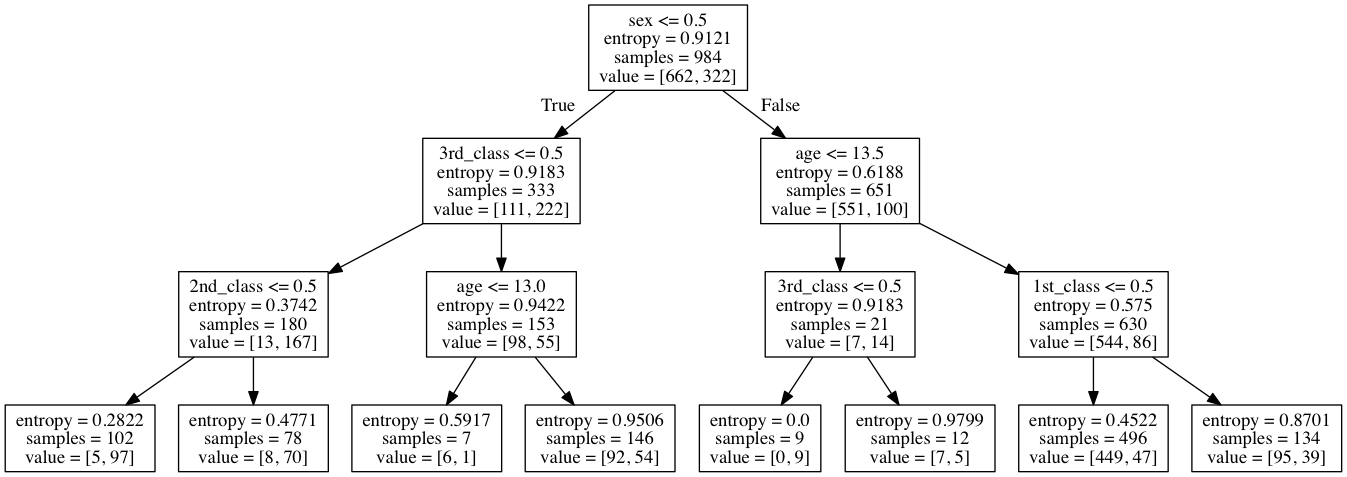

In [15]:
import pydotplus
from sklearn.externals.six import StringIO

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=['age','sex','1st_class','2nd_class','3rd_class']) 

graph = pydotplus.pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("titanic.png")
from IPython.core.display import Image 
Image(filename='titanic.png')

훈련 데이터의 정확도(accuracy), 정밀도(precision), 재현율(recall), f1을 측정한다.

In [16]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.838 



변화량을 줄이고 좀 더 나은 성능을 얻기 위해, 단일 잔류(leave-one-out) 교차 검증을 실행한다.

In [17]:
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from scipy.stats import sem

def loo_cv(X_train,y_train,clf):
    # 단일 잔류(Leave-One-Out) 교차 검증 실행한다
    loo = LeaveOneOut(X_train[:].shape[0])
    scores=np.zeros(X_train[:].shape[0])
    for train_index,test_index in loo:
        X_train_cv, X_test_cv= X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv= y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred=clf.predict(X_test_cv)
        scores[test_index]=metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print (
        ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))
    )



In [18]:
loo_cv(X_train, y_train,clf)


Mean score: 0.837 (+/-0.012)


랜덤 포레스트(Random Forests)을 사용하여 성능을 향상한다.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,random_state=33)
clf = clf.fit(X_train,y_train)
loo_cv(X_train,y_train,clf)

미래 데이터에 대한 성능을 평가하기 위해, 훈련 데이터와 테스트 데이터로 평가한다.

In [20]:
clf_dt=tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf_dt.fit(X_train,y_train)
measure_performance(X_test,y_test,clf_dt)



Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329
 

Confusion matrix
[[193   9]
 [ 59  68]] 

